In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
const.BETA4

32.70989286766126

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [3]:
# Compute the Mott-Massey results
mm = LocalSystem(1.5, nq=300)
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)
mm_evals

array([-0.06476101, -0.04422779, -0.02740757, -0.01466236, -0.00611672,
       -0.00156346, -0.00012025])

In [4]:
Rs = const.BETA4/np.linspace(10, 40, 50)

In [5]:
Ri = Rs[0]
ls = LocalSystem(Ri, nq=250)

In [6]:
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(0, 0), 1, ls.q, ls.wq)
evals

array([-2.20771225e-03, -6.07448637e-04, -2.39560318e-05])

In [7]:
def evals_and_evecs(g, ls):
    return bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)

In [8]:
def froot(g, ls):
    evals, evecs = evals_and_evecs(g, ls)
    evals = evals[np.where(np.abs(evals) > 1e-9)[0]]
    assert evals.size == 7, f'There are {evals.size} bounds states.'
    return (mm_evals[6] - evals[6]) / mm_evals[6]

In [9]:
guess = -0.050715
froot(guess, ls)

-0.00037418217488155295

In [10]:
class Spectrum:
    def __init__(self, ls, g_lo):
        evals, evecs = evals_and_evecs(g_lo, ls)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.g_lo = g_lo

In [11]:
glos = np.zeros(Rs.size)
specs = []
for (i, Ri) in enumerate(Rs):
    ls = LocalSystem(Ri, nq=250)
    result = optimize.fsolve(froot, guess, args=(ls), xtol=1e-12)
    glo = result[0]
    
    glos[i] = glo
    specs.append(Spectrum(ls, glo))
    
    if i < 5:
        guess = glo
    else:
        curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = curve(Rs[i+1])
        except:
            break
    
    print(f'i = {i}  R = {Ri:.4e}  g_LO = {glo:.4e}')

i = 0  R = 3.2710e+00  g_LO = -5.0713e-02
i = 1  R = 3.0823e+00  g_LO = -5.4006e-02
i = 2  R = 2.9142e+00  g_LO = -5.6623e-02


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


i = 3  R = 2.7634e+00  g_LO = -5.8512e-02
i = 4  R = 2.6275e+00  g_LO = -5.9895e-02
i = 5  R = 2.5044e+00  g_LO = -6.0964e-02
i = 6  R = 2.3922e+00  g_LO = -6.1674e-02
i = 7  R = 2.2897e+00  g_LO = -6.1855e-02
i = 8  R = 2.1956e+00  g_LO = -6.1366e-02
i = 9  R = 2.1089e+00  g_LO = -6.0179e-02
i = 10  R = 2.0288e+00  g_LO = -5.8346e-02
i = 11  R = 1.9546e+00  g_LO = -5.5922e-02
i = 12  R = 1.8856e+00  g_LO = -5.2918e-02
i = 13  R = 1.8213e+00  g_LO = -4.9326e-02
i = 14  R = 1.7613e+00  g_LO = -4.5155e-02
i = 15  R = 1.7051e+00  g_LO = -4.0450e-02
i = 16  R = 1.6524e+00  g_LO = -3.5293e-02
i = 17  R = 1.6028e+00  g_LO = -2.9808e-02
i = 18  R = 1.5561e+00  g_LO = -2.4125e-02
i = 19  R = 1.5121e+00  g_LO = -1.8259e-02
i = 20  R = 1.4704e+00  g_LO = -1.1949e-02
i = 21  R = 1.4311e+00  g_LO = -4.5992e-03
i = 22  R = 1.3937e+00  g_LO = 4.7045e-03
i = 23  R = 1.3583e+00  g_LO = 1.7131e-02
i = 24  R = 1.3246e+00  g_LO = 3.3987e-02
i = 25  R = 1.2926e+00  g_LO = 5.6647e-02
i = 26  R = 1.2620e+00

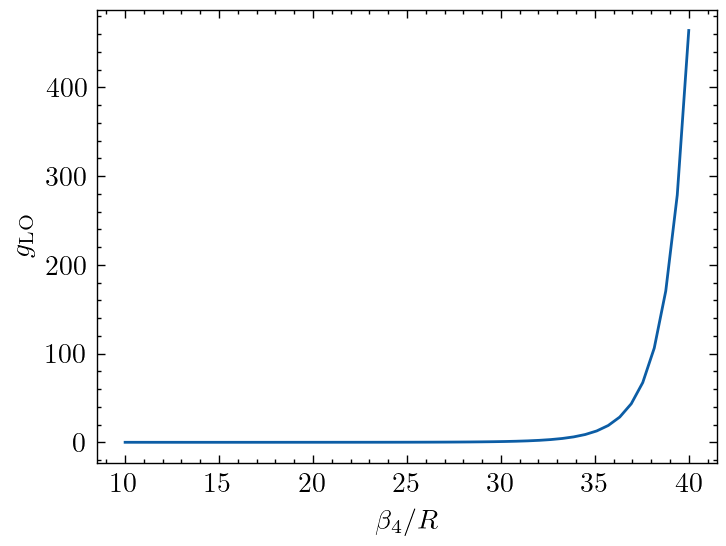

In [12]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs, glos)

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

In [13]:
lo_specs = np.array([spec.lo_evals for spec in specs])

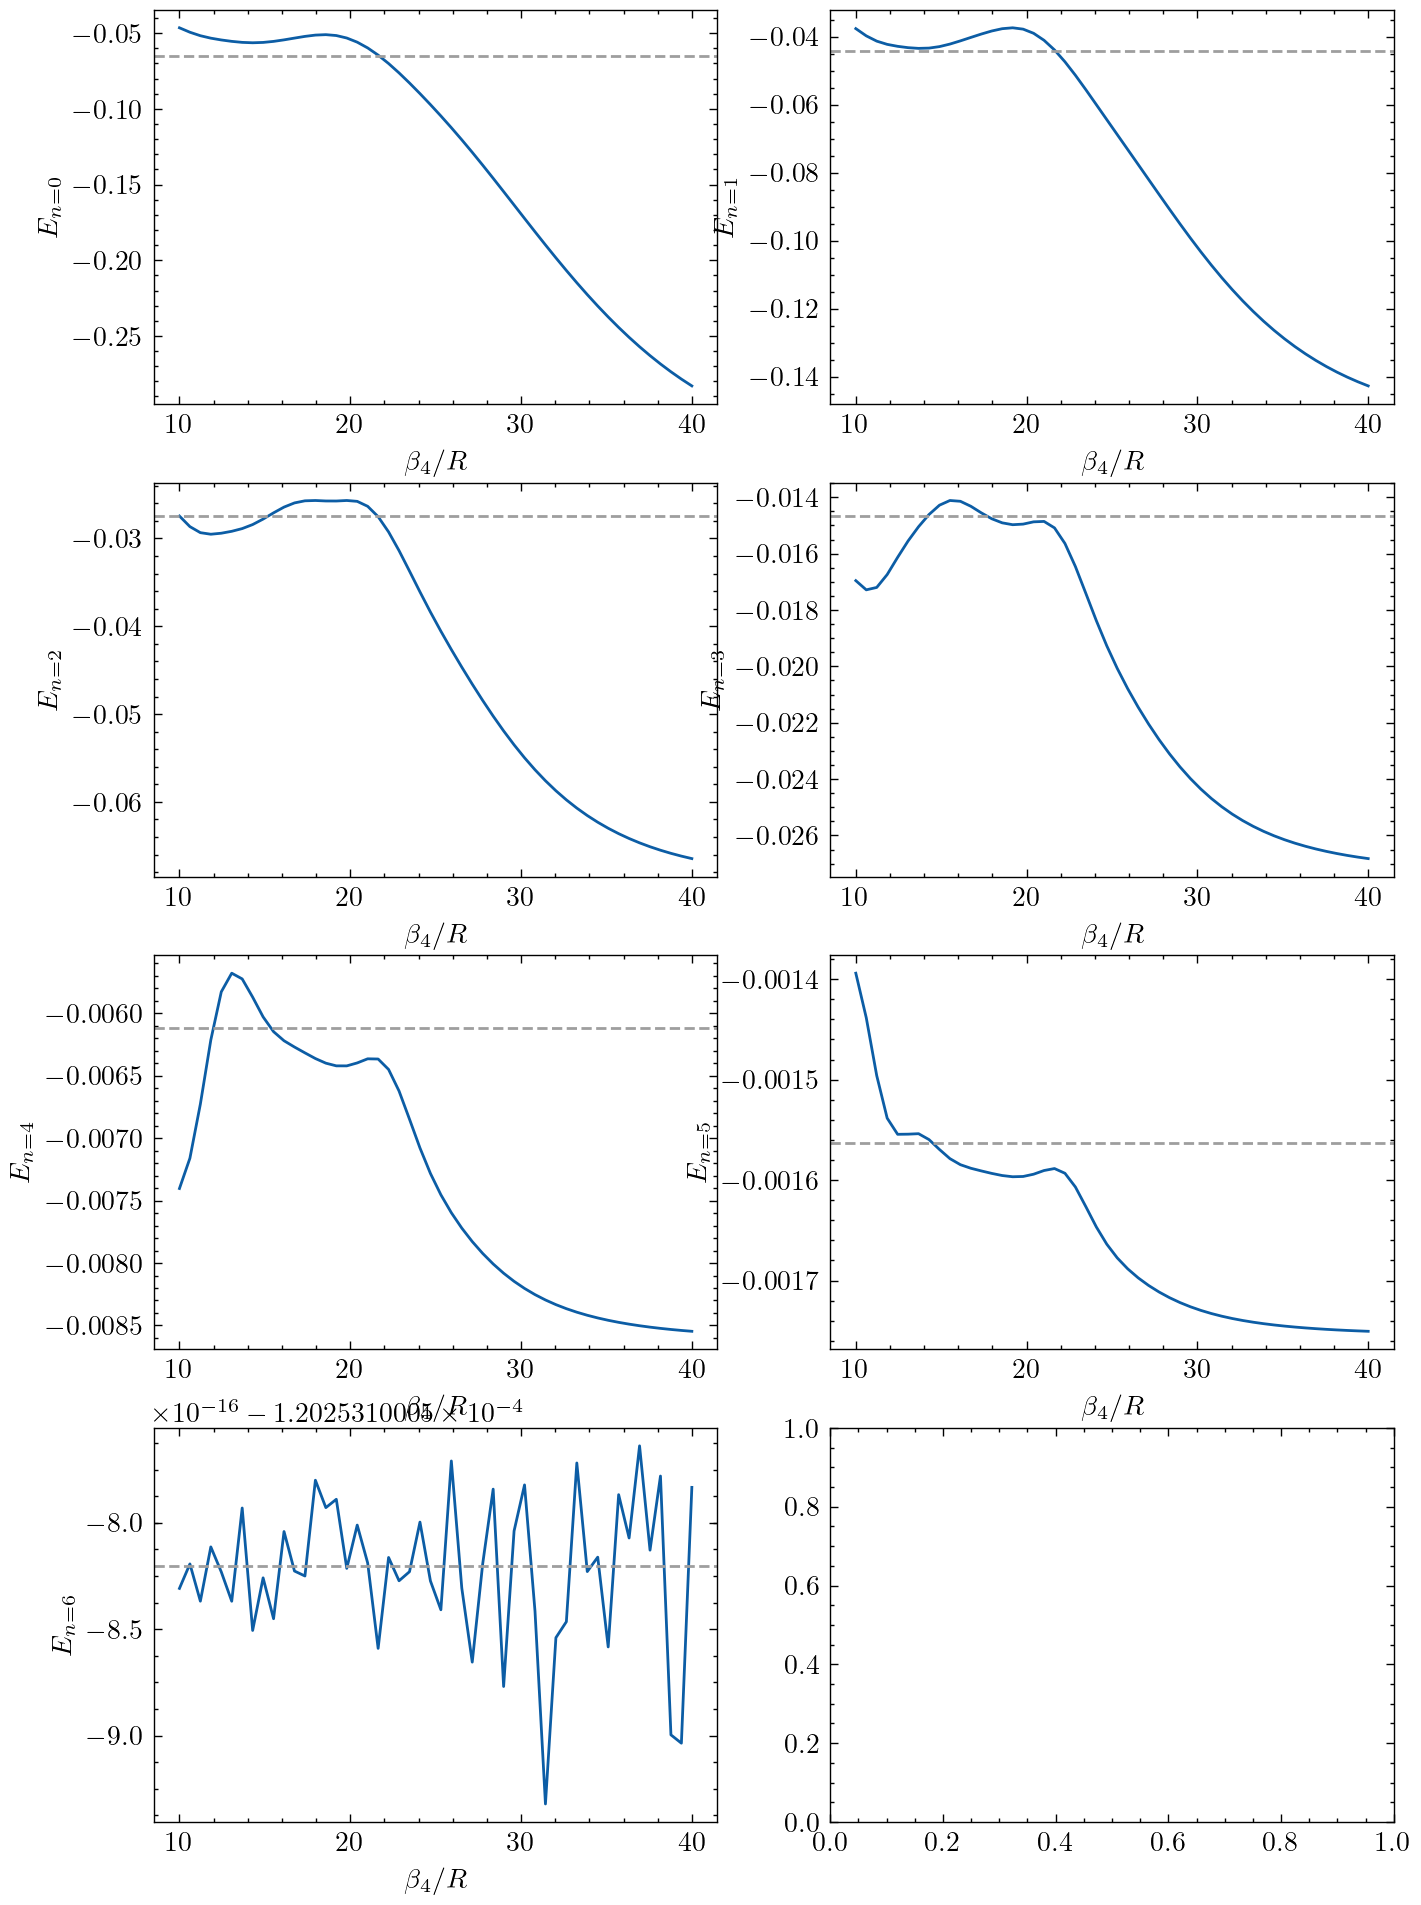

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, lo_specs[:, i])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

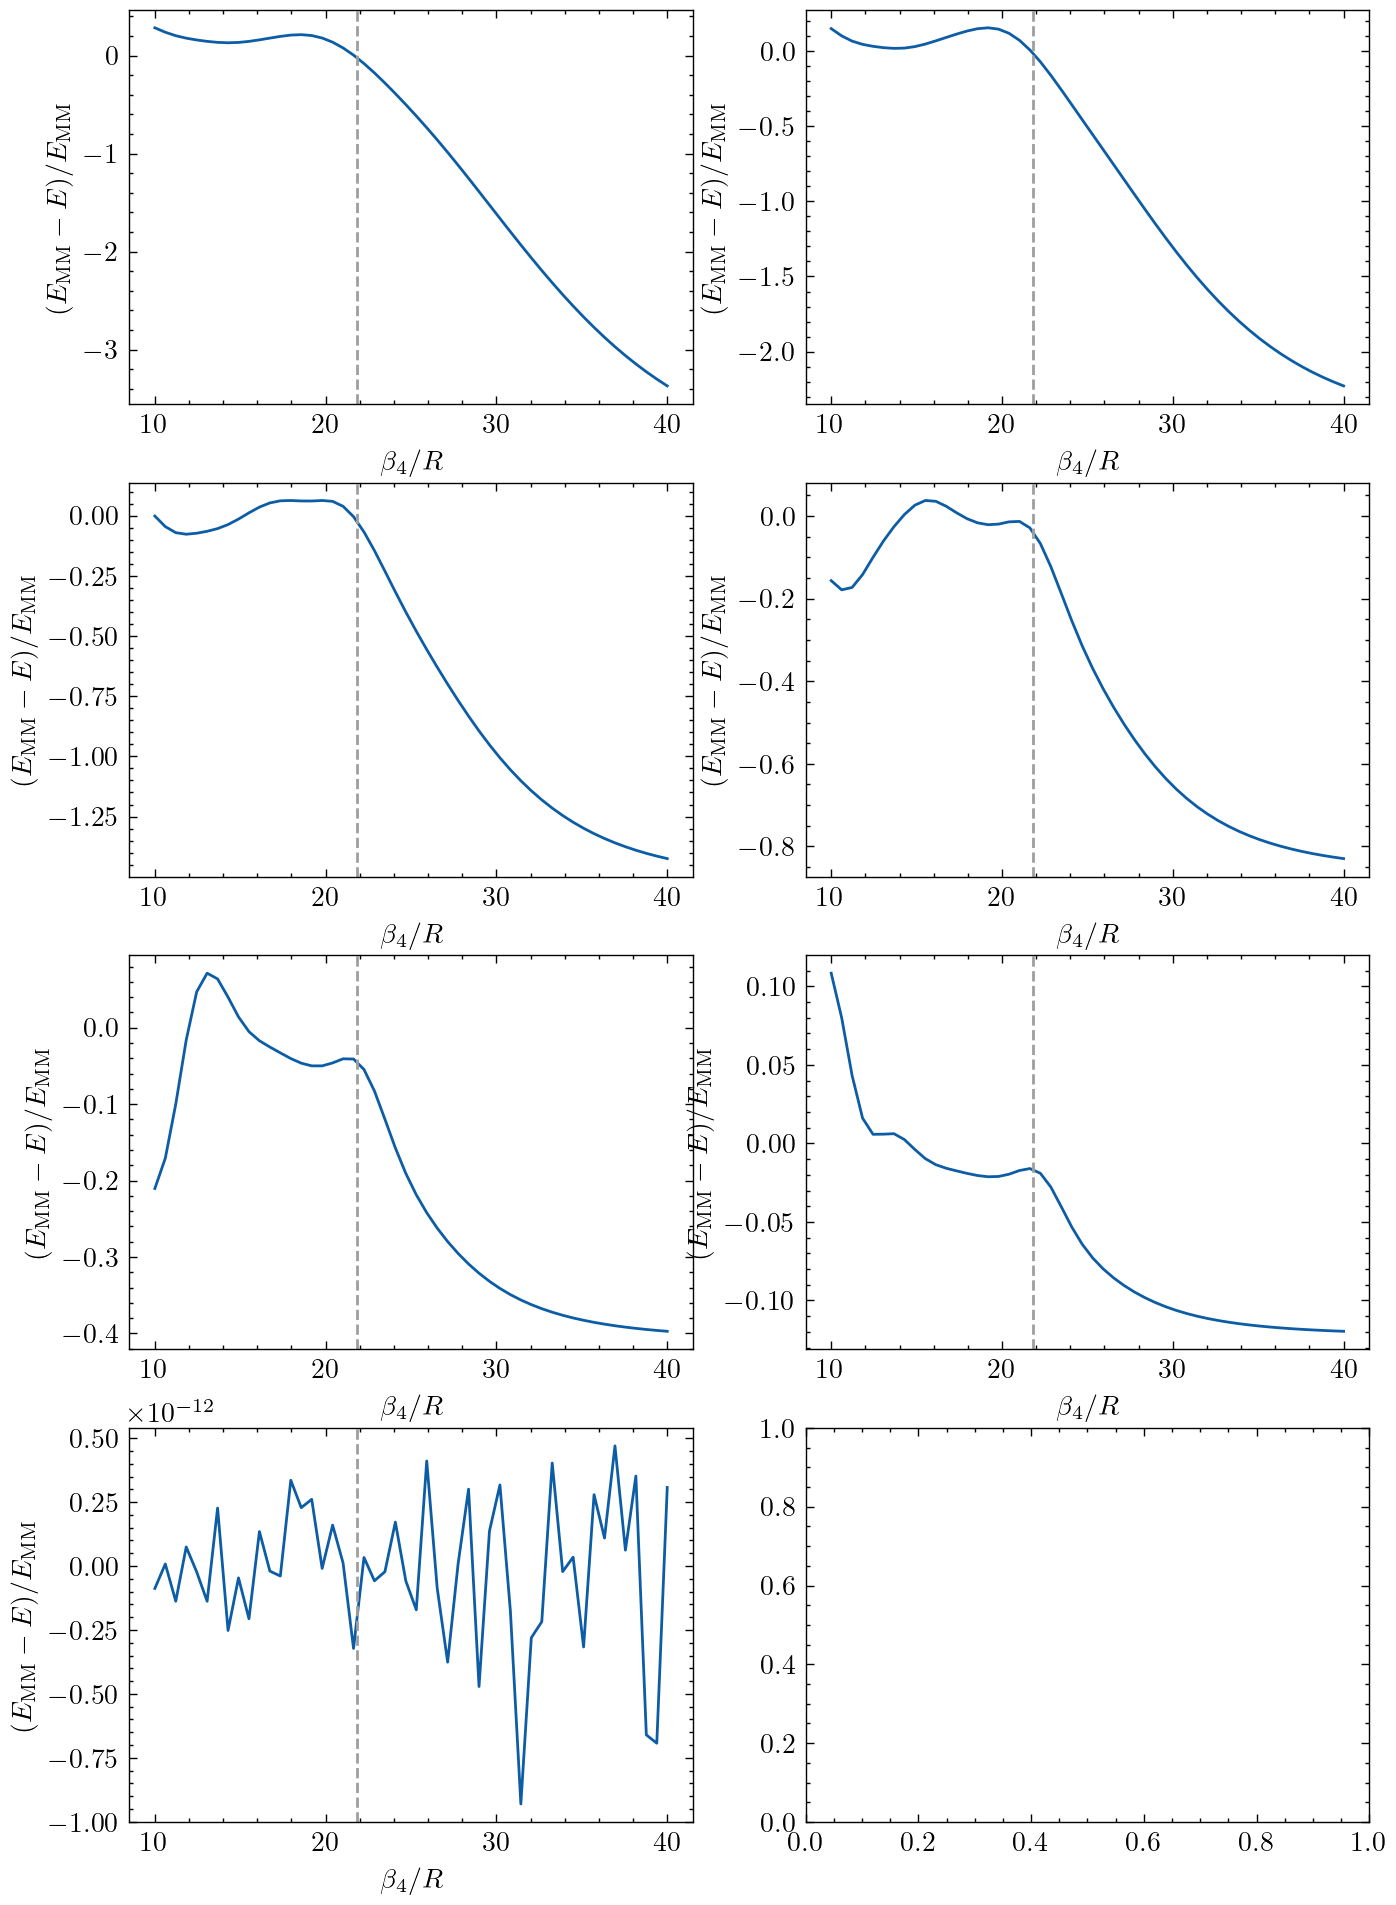

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

In [16]:
np.savetxt('rgflow_local_lo_B6_fix.txt', np.vstack((Rs, glos)).T, header='R  g_LO')

In [17]:
np.savetxt('spectra_local_lo_B6_fix.txt', np.vstack((Rs, lo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')